In [130]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import random as rng
from tqdm import tqdm
%matplotlib inline
import sys
sys.path.append("/cluster/scratch/jingyli/interpretable/understanding_unet")
from utils.draw import plot_attr_map

%load_ext autoreload
%autoreload 2

rng.seed(12345)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# path
figure_log_root = Path('/cluster/scratch/jingyli/interpretable/data_intermediate/visualization')

In [28]:
def read_results(DATE, TIME, CHANNEL, W, MODEL, method):
    filename = f"{method}_{DATE}_{TIME}_C{CHANNEL}-W{W}.npy"
    filepath = figure_log_root / f"{MODEL}" / f"{DATE}_{TIME}" / method / filename
    if os.path.exists(filepath):
        arr = np.load(filepath)
        return arr
    else:
        return None


In [120]:
MODEL = "resUnet"
DATE = "2019-07-01"
TIME = 144
CHANNEL = 0
method = "watershed" 
quantile = 0.75

visualize_method = "exist"  # "aggregate"

# To store multiple watershed marker layers
watershed_layer = []

idx = 1
for i in tqdm(range(1,22,1)):
    for j in range(0,22,1):
        W = f"{i}_{j}"
        arr = read_results(DATE, TIME, CHANNEL, W, MODEL, method)
        if arr is None:
            continue
        markers = arr[...,0]
        attr_values = arr[...,1]
        markers_ = np.where((markers > 0) & (markers < 255), idx, 0)
#         markers = arr

        # Filter out hotspots by attribution value
        flat_channel = attr_values[markers_ == idx]
        flat_channel = np.sort(flat_channel)
        threshold = flat_channel[np.round(quantile * flat_channel.shape[0]).astype(int)]
        if visualize_method == "exist":
            markers_ = np.where(attr_values >= threshold, idx, 0)
        elif visualize_method == "aggregate":
            attr_values[attr_values < threshold] = 0
            markers_ = attr_values
        # Save
        watershed_layer.append(markers_)       
        idx += 1
watershed_layer = np.array(watershed_layer)
print(f"Loaded {len(watershed_layer)} in total")

100%|██████████| 21/21 [00:01<00:00, 13.48it/s]


Loaded 419 in total


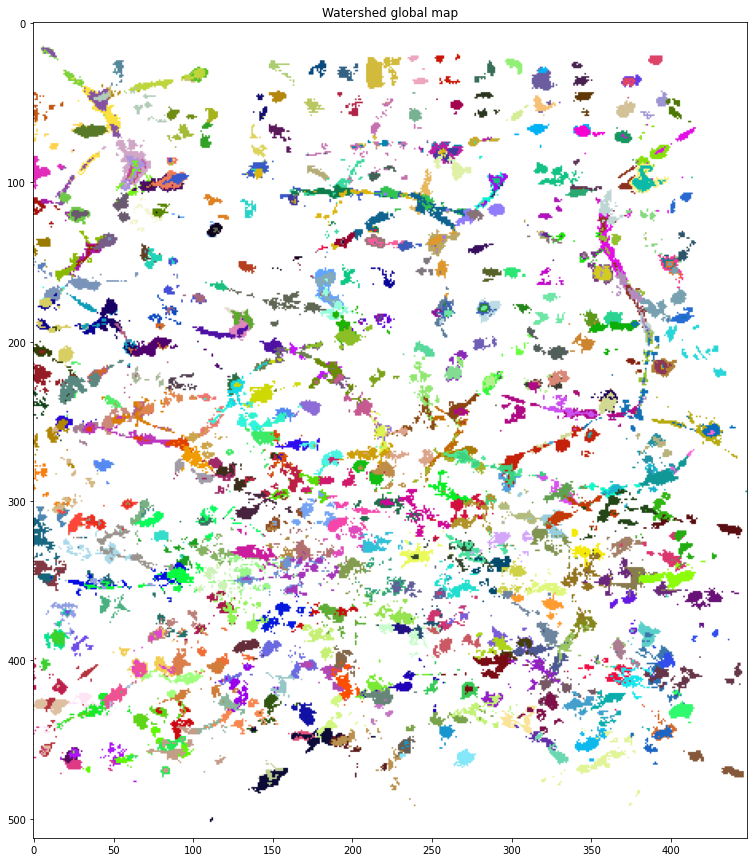

In [75]:
# Plot if contribution exists
if visualize_method == "exist":
    # Generate random colors
    colors = []
    for i in range(watershed_layer.shape[0]):
        colors.append((rng.randint(0, 256), rng.randint(0, 256), rng.randint(0, 256)))

    # Create the result image
    dst = np.ones((watershed_layer.shape[1], watershed_layer.shape[2], 4), dtype=np.uint8) * 255
    # dst[..., 3] = np.ones(watershed_layer.shape[1:])*100
    # Fill labeled objects with random colors
    for i in range(watershed_layer.shape[1]):
        for j in range(watershed_layer.shape[2]):
            # Filter layers where has marker
            layers = watershed_layer[:, i, j]
            markers = np.unique(layers[np.nonzero(layers)])
            if len(markers)==0:
                continue
            index = markers[-1]
            dst[i, j, :3] = colors[index - 1]
    # Visualize the final image
    fig, ax = plt.subplots(1,1, figsize=(15,15))
    im = ax.imshow(dst)
    ax.set_title(f"Watershed global map")
    plt.savefig("watershed_global.png")
    plt.show()

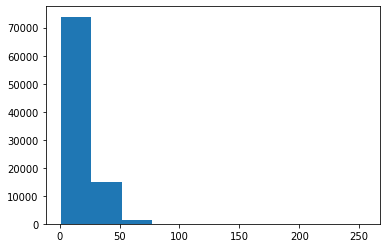

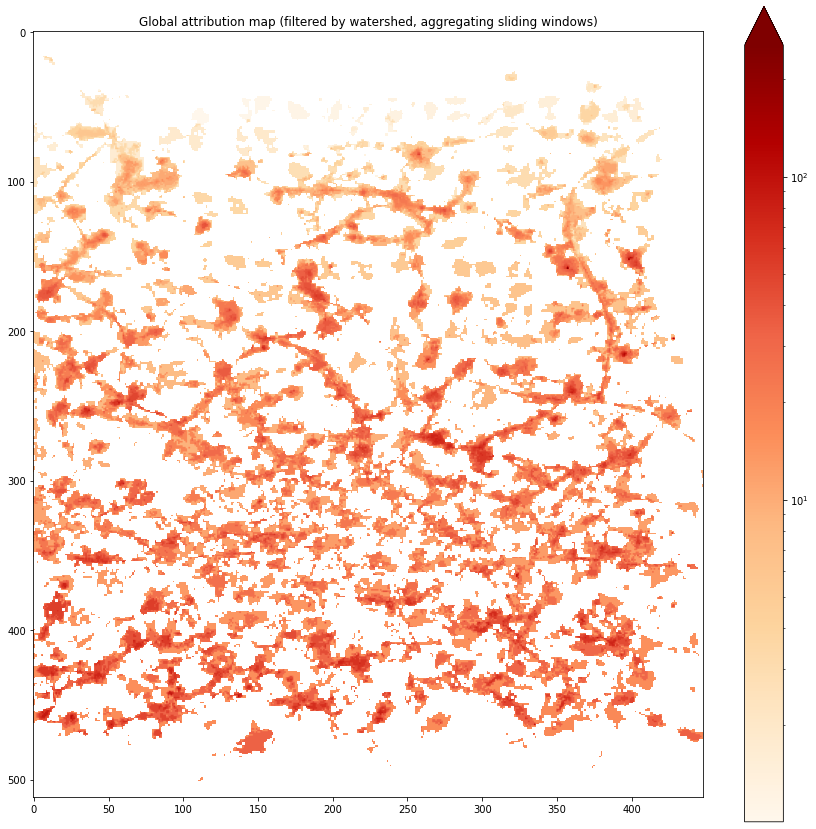

In [138]:
if visualize_method == "aggregate":
    # Plot aggregation visualization method
    agg_layers = np.sum(watershed_layer, axis=0) 
    agg_layers = (agg_layers - np.min(agg_layers))/(np.max(agg_layers)- np.min(agg_layers)) * 255
    agg_layers = np.ma.masked_where(agg_layers < 1, agg_layers)
    plt.hist(agg_layers.flatten())

    cmap = mpl.cm.get_cmap("OrRd").copy()
    cmap.set_bad(color="white")

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    im = plot_attr_map(agg_layers, ax, cmap, norm="log")
    ax.set_title("Global attribution map (filtered by watershed, aggregating sliding windows)")
    fig.colorbar(im, ax=ax, extend='max')
    plt.savefig("watershed_global_agg.png")